
# Façade Parametric Reconstruction — DBSCAN + Full Geometry (Colab)

**Pipeline**

1) Load façade mask (black=windows) and optional photo.  
2) Detect windows → **DBSCAN** cluster into floors (rows) & bays (cols).  
3) Build parametric **grammar** (sizes, spacing, offsets, shape).  
4) Edit via natural language (with explicit setters).  
5) Regenerate **full vector geometry** (rect/arch) and preview & overlay.  
6) Export **SVG**, **DXF**, **JSON**.  
7) Mini UI for quick edits.

**Why DBSCAN?** More robust grouping than naive rounding; avoids phantom extra rows/cols.


In [1]:

#@title 0) Setup
!pip -q install pillow numpy opencv-python lxml cairosvg ezdxf ipywidgets scikit-learn openai==1.51.0
from IPython.display import display, SVG
import numpy as np, json, io, re, math, os
from PIL import Image, ImageDraw
import cv2
from lxml import etree
import cairosvg, ezdxf, ipywidgets as widgets
from sklearn.cluster import DBSCAN

print("✅ Environment ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
✅ Environment ready


In [2]:

#@title 1) Upload façade image (optional) + B/W mask (required)
from google.colab import files

print("Upload a façade photo (optional) and a B/W mask (required).")
print("Mask: white background, black windows (auto-invert handled).")
uploaded = files.upload()
names = list(uploaded.keys())
assert len(names) >= 1, "Upload at least the B/W mask (SVG/PNG/JPG)."
print("Uploaded:", names)


Upload a façade photo (optional) and a B/W mask (required).
Mask: white background, black windows (auto-invert handled).


Saving modified_windows (10).svg to modified_windows (10).svg
Uploaded: ['modified_windows (10).svg']


Mask loaded. Window pixels: 363724 Canvas: (1017, 1018)


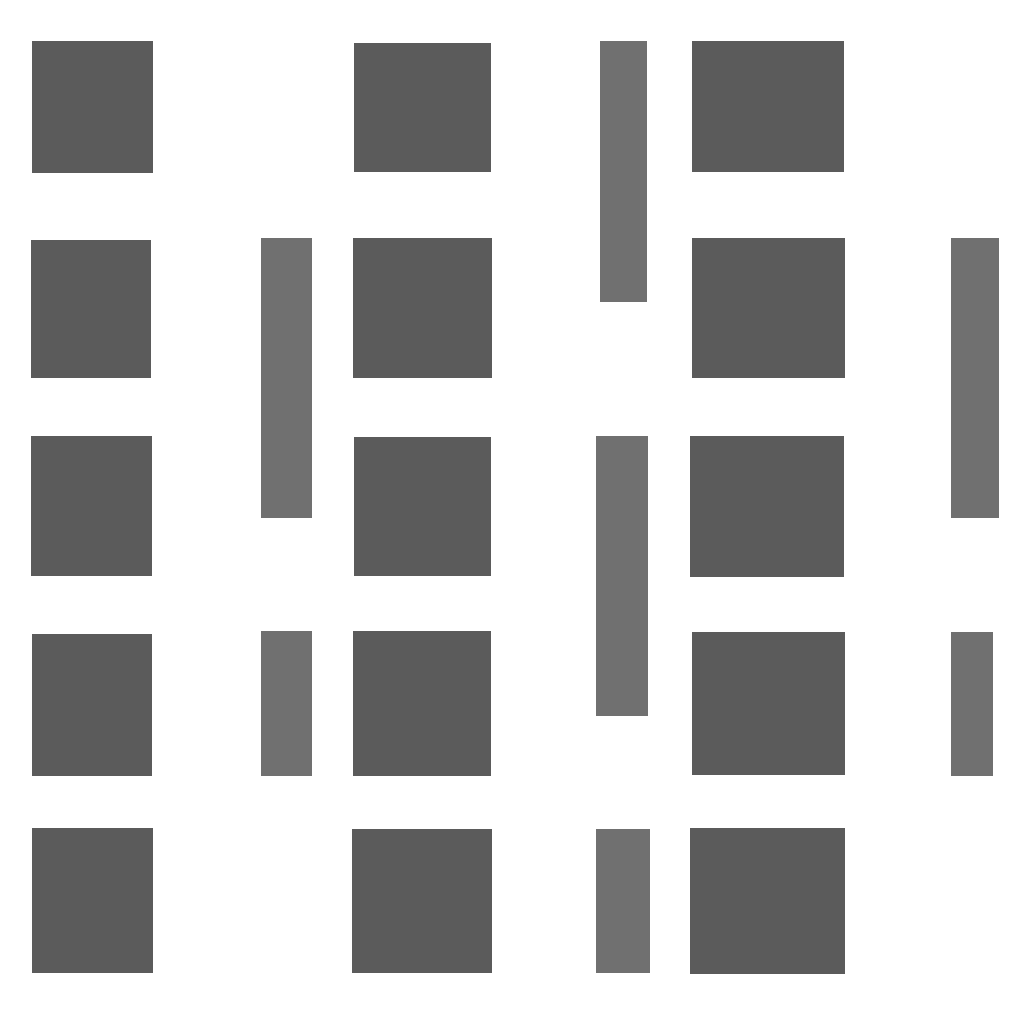

In [3]:

#@title 2) Load mask (SVG or raster) → raster + threshold (auto-invert) & keep façade image
from PIL import Image

mask_name, img_name = None, None
for n in names:
    low = n.lower()
    if any(low.endswith(x) for x in [".svg",".png",".jpg",".jpeg",".webp"]):
        if "mask" in low or low.endswith(".svg"):
            mask_name = n if mask_name is None else mask_name
        else:
            img_name = n

assert mask_name is not None, "Couldn't find a mask file. Include 'mask' in its name or upload an SVG."

def rasterize_svg(svg_path, out_w=2048, out_h=2048):
    parser = etree.XMLParser(remove_comments=True)
    tree = etree.parse(svg_path, parser)
    root = tree.getroot()
    NS = {"svg":"http://www.w3.org/2000/svg"}
    # remove labels
    for t in root.findall(".//svg:text", namespaces=NS):
        p = t.getparent()
        if p is not None: p.remove(t)
    # white background
    def add_white_background(svg_root):
        w = svg_root.get("width"); h = svg_root.get("height")
        try:
            W = int(float(w.replace("px",""))) if w else out_w
            H = int(float(h.replace("px",""))) if h else out_h
        except:
            W, H = out_w, out_h
        bg = etree.Element("{http://www.w3.org/2000/svg}rect")
        bg.set("x","0"); bg.set("y","0"); bg.set("width", str(W)); bg.set("height", str(H)); bg.set("fill","#ffffff")
        svg_root.insert(0, bg); return W, H
    Wc, Hc = add_white_background(root)
    png = cairosvg.svg2png(bytestring=etree.tostring(root), output_width=Wc, output_height=Hc, background_color="white")
    return Image.open(io.BytesIO(png)).convert("L")

# load mask
if mask_name.lower().endswith(".svg"):
    mask_gray = rasterize_svg(mask_name)
else:
    mask_gray = Image.open(mask_name).convert("L")

arr = np.array(mask_gray)
th = (arr < 128).astype(np.uint8)  # black→1, white→0
# auto-invert if windows are white on black
if th.mean() > 0.60:
    th = 1 - th

H, W = th.shape
facade_img = None
if img_name:
    try:
        facade_img = Image.open(img_name).convert("RGBA").resize((W,H))
    except Exception:
        facade_img = None

print("Mask loaded. Window pixels:", int(th.sum()), "Canvas:", (W,H))
display(mask_gray)


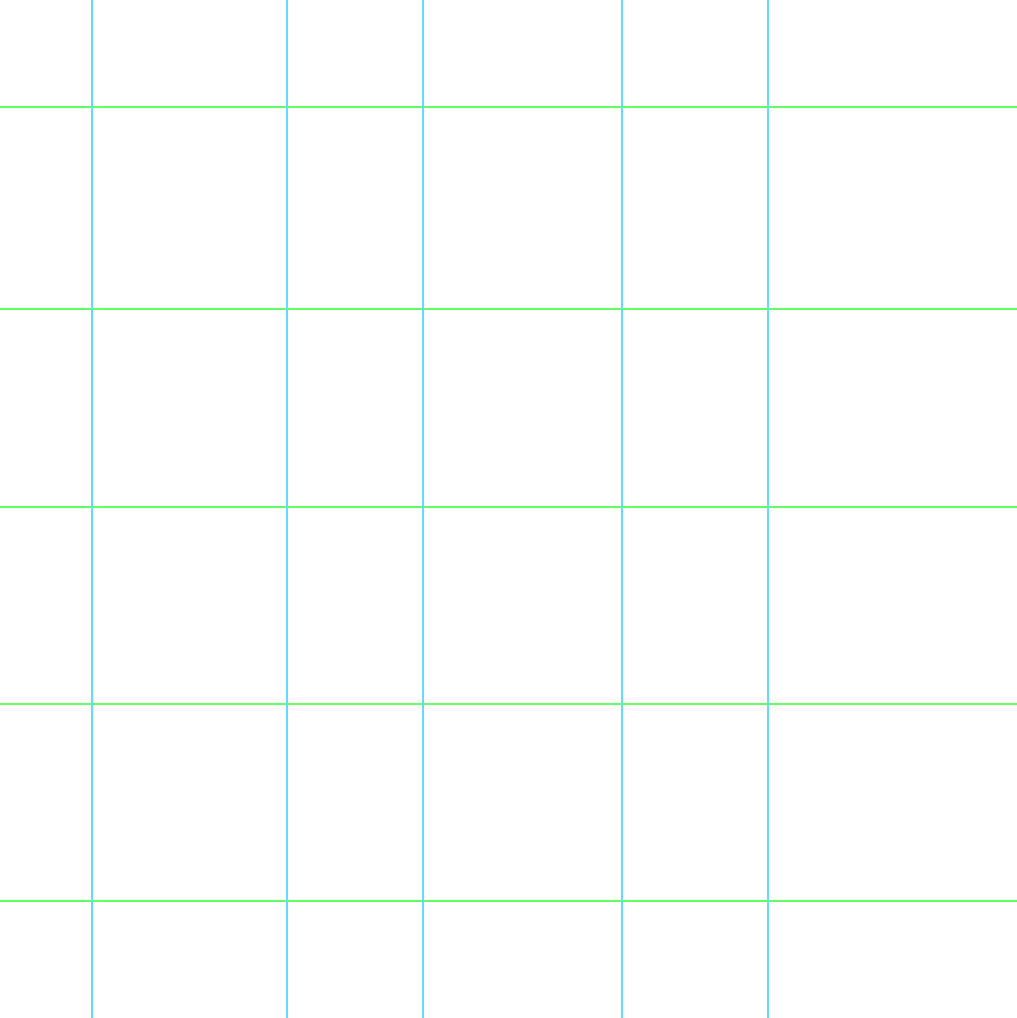

Detected windows: 17  →  floors=5, bays=5


In [4]:

#@title 3) Detect windows → robust clustering into floors/bays (DBSCAN) + guides
# Connected components
num_labels, labels, stats, cents = cv2.connectedComponentsWithStats(th, connectivity=8)
areas = stats[:, cv2.CC_STAT_AREA]
# Filter tiny blobs (noise). Increase percentile if you still get noise.
valid_idx = [i for i in range(1, num_labels) if areas[i] > np.percentile(areas[1:], 20)]
wins = []
for i in valid_idx:
    x, y, w, h, a = stats[i]
    cx, cy = cents[i]
    wins.append(dict(x=int(x), y=int(y), w=int(w), h=int(h), cx=float(cx), cy=float(cy), a=int(a)))
assert wins, "No windows detected. Check your mask (black windows on white)."

xs = np.array([w["cx"] for w in wins])
ys = np.array([w["cy"] for w in wins])
ws = np.array([w["w"]  for w in wins])
hs = np.array([w["h"]  for w in wins])

# DBSCAN eps heuristics: ~60% of median window size along axis
eps_y = max(8, int(np.median(hs) * 0.6))
eps_x = max(8, int(np.median(ws) * 0.6))

def cluster_axis(vals, eps):
    vals = vals.reshape(-1,1)
    labels = DBSCAN(eps=float(eps), min_samples=1).fit(vals).labels_
    uniq = np.unique(labels)
    means = [vals[labels==u].mean() for u in uniq]
    order = np.argsort(means)
    remap = {int(uniq[i]): int(i) for i in order}
    ids = np.array([remap[int(l)] for l in labels])
    return ids, len(uniq)

row_ids, n_rows = cluster_axis(ys, eps_y)
col_ids, n_cols = cluster_axis(xs, eps_x)

# Debug guide lines
dbg = Image.new("RGBA", (W,H), (0,0,0,0))
draw = ImageDraw.Draw(dbg)
for r in range(n_rows):
    y_med = int(np.median(ys[row_ids==r]))
    draw.line([(0,y_med),(W,y_med)], fill=(0,255,0,160), width=2)
for c in range(n_cols):
    x_med = int(np.median(xs[col_ids==c]))
    draw.line([(x_med,0),(x_med,H)], fill=(0,200,255,160), width=2)

base = facade_img if facade_img is not None else Image.new("RGBA",(W,H),(255,255,255,255))
preview_guides = Image.alpha_composite(base, dbg)
display(preview_guides)
print(f"Detected windows: {len(wins)}  →  floors={n_rows}, bays={n_cols}")


In [5]:

#@title 4) Build initial grammar (sizes, spacing, offsets, shape)
def median_spacing(vals):
    s = np.sort(vals); dif = np.diff(s); dif = dif[dif>0]
    return int(np.median(dif)) if len(dif)>0 else max(W,H)

avg_w = int(np.median([w['w'] for w in wins]))
avg_h = int(np.median([w['h'] for w in wins]))
sx = median_spacing(np.array([w['cx'] for w in wins]))
sy = median_spacing(np.array([w['cy'] for w in wins]))
offset_x = int(np.min([w['cx'] for w in wins]) - avg_w//2)
offset_y = int(np.min([w['cy'] for w in wins]) - avg_h//2)

grammar = {
    "canvas": {"width": int(W), "height": int(H)},
    "grid": {
        "floors": int(n_rows),
        "bays": int(n_cols),
        "spacing_x": int(sx),
        "spacing_y": int(sy),
        "offset_x": int(offset_x),
        "offset_y": int(offset_y)
    },
    "window": {
        "width": int(avg_w),
        "height": int(avg_h),
        "shape": "rect",
        "inset": 0
    },
    "patterns": {
        "skip_every_nth_col": 0,
        "skip_every_nth_row": 0
    }
}
print(json.dumps(grammar, indent=2))

# --- build occupancy map & per-cell stats from the mask ---
# uses: wins, row_ids, col_ids, n_rows, n_cols defined in Step 3
import numpy as np

# occupancy[r][c] = True if mask has a window in that cell
occ = [[False]*int(n_cols) for _ in range(int(n_rows))]
cell_stats = {}  # (r,c) -> dict(med_cx, med_cy, med_w, med_h)

for i, w in enumerate(wins):
    r = int(row_ids[i]); c = int(col_ids[i])
    occ[r][c] = True
    key = (r,c)
    if key not in cell_stats:
        cell_stats[key] = {"cx": [], "cy": [], "w": [], "h": []}
    cell_stats[key]["cx"].append(w["cx"])
    cell_stats[key]["cy"].append(w["cy"])
    cell_stats[key]["w"].append(w["w"])
    cell_stats[key]["h"].append(w["h"])

# collapse to medians (so we draw where the mask really is)
for key, d in cell_stats.items():
    d["med_cx"] = int(np.median(d["cx"]))
    d["med_cy"] = int(np.median(d["cy"]))
    d["med_w"]  = int(np.median(d["w"]))
    d["med_h"]  = int(np.median(d["h"]))
    # also provide top-left anchor estimated from mask (cx,cy) and size
    d["x"] = int(d["med_cx"] - d["med_w"]/2)
    d["y"] = int(d["med_cy"] - d["med_h"]/2)

grammar["occupancy"] = occ
# store stats in a JSON-serializable form
grammar["cell_stats"] = {f"{r}_{c}": cell_stats[(r,c)] for (r,c) in cell_stats}
# default: trace only mask-present cells
grammar["trace_mask_only"] = True
print("Occupancy map built. trace_mask_only =", grammar["trace_mask_only"])



{
  "canvas": {
    "width": 1017,
    "height": 1018
  },
  "grid": {
    "floors": 5,
    "bays": 5,
    "spacing_x": 0,
    "spacing_y": 35,
    "offset_x": 22,
    "offset_y": 36
  },
  "window": {
    "width": 137,
    "height": 141,
    "shape": "rect",
    "inset": 0
  },
  "patterns": {
    "skip_every_nth_col": 0,
    "skip_every_nth_row": 0
  }
}
Occupancy map built. trace_mask_only = True


In [6]:
# Auto-align the parametric grid to the mask's medians
import numpy as np, json

def align_grid_to_mask(g):
    stats = g.get("cell_stats", {})
    occ   = g.get("occupancy", [])
    if not occ or not stats:
        print("No occupancy/stats found — run Steps 2–4 first.")
        return g

    rows = len(occ)
    cols = len(occ[0]) if rows else 0

    row_y = []
    col_x = []

    # collect median top-left y per row, x per column from the mask
    for r in range(rows):
        ys = [stats[f"{r}_{c}"]["y"] for c in range(cols) if f"{r}_{c}" in stats]
        if ys: row_y.append(int(np.median(ys)))
    for c in range(cols):
        xs = [stats[f"{r}_{c}"]["x"] for r in range(rows) if f"{r}_{c}" in stats]
        if xs: col_x.append(int(np.median(xs)))

    if len(row_y) >= 1: row_y.sort()
    if len(col_x) >= 1: col_x.sort()

    if row_y:
        g["grid"]["offset_y"]  = int(row_y[0])
    if col_x:
        g["grid"]["offset_x"]  = int(col_x[0])
    if len(row_y) > 1:
        g["grid"]["spacing_y"] = int(np.median(np.diff(row_y)))
    if len(col_x) > 1:
        g["grid"]["spacing_x"] = int(np.median(np.diff(col_x)))

    print("Aligned grid →",
          "offset_x:", g["grid"]["offset_x"],
          "offset_y:", g["grid"]["offset_y"],
          "spacing_x:", g["grid"]["spacing_x"],
          "spacing_y:", g["grid"]["spacing_y"])
    return g

grammar = align_grid_to_mask(grammar)
print(json.dumps(grammar["grid"], indent=2))


Aligned grid → offset_x: 31 offset_y: 40 spacing_x: 162 spacing_y: 196
{
  "floors": 5,
  "bays": 5,
  "spacing_x": 162,
  "spacing_y": 196,
  "offset_x": 31,
  "offset_y": 40
}


In [7]:
#@title 5) Edit grammar via natural language + explicit setters
def apply_rules(s, grammar):
    """Applies grammar edits based on input string s."""
    g = grammar # use a shorthand

    # size (word boundaries)
    w_match = re.search(r"\bwidth\s+(\d+)(px)?\b", s)
    if w_match: g["window"]["width"] = int(w_match.group(1))
    h_match = re.search(r"\bheight\s+(\d+)(px)?\b", s)
    if h_match: g["window"]["height"] = int(h_match.group(1))
    i_match = re.search(r"\binset\s+(\d+)(px)?\b", s)
    if i_match: g["window"]["inset"] = int(i_match.group(1))

    # grid (word boundaries)
    r_match = re.search(r"\b(?:floors|rows)\s+(\d+)\b", s)
    if r_match: g["grid"]["floors"] = int(r_match.group(1))
    c_match = re.search(r"\b(?:bays|cols|columns)\s+(\d+)\b", s)
    if c_match: g["grid"]["bays"] = int(c_match.group(1))
    sx_match = re.search(r"\bspacing\s+x\s+(\d+)(px)?\b", s)
    if sx_match: g["grid"]["spacing_x"] = int(sx_match.group(1))
    sy_match = re.search(r"\bspacing\s+y\s+(\d+)(px)?\b", s)
    if sy_match: g["grid"]["spacing_y"] = int(sy_match.group(1))
    ox_match = re.search(r"\boffset\s+x\s+(\d+)(px)?\b", s)
    if ox_match: g["grid"]["offset_x"] = int(ox_match.group(1))
    oy_match = re.search(r"\boffset\s+y\s+(\d+)(px)?\b", s)
    if oy_match: g["grid"]["offset_y"] = int(oy_match.group(1))

    # patterns
    skipc_match = re.search(r"\bskip\s+cols?\s+(\d+)\b", s)
    if skipc_match: g["patterns"]["skip_every_nth_col"] = int(skipc_match.group(1))
    skipr_match = re.search(r"\bskip\s+rows?\s+(\d+)\b", s)
    if skipr_match: g["patterns"]["skip_every_nth_row"] = int(skipr_match.group(1))

        # shape (word boundaries)
    if re.search(r"\barch(es)?\b", s):
        g["window"]["shape"] = "arch"
    if re.search(r"\brect(angles?|s)?\b", s) or re.search(r"\brect\b", s):
        g["window"]["shape"] = "rect"
    if g["window"].get("shape") not in ("rect","arch"):
        g["window"]["shape"] = "rect"

    # trace modes
    if re.search(r"\btrace\s+on\b", s):
        g["trace_mode"] = "on"
    if re.search(r"\btrace\s+off\b", s):
        g["trace_mode"] = "off"
    if re.search(r"\btrace\s+grow\b", s):
        g["trace_mode"] = "grow"

    return g


In [8]:
# Auto-align the parametric grid to the mask's medians
import numpy as np, json

def align_grid_to_mask(g):
    stats = g.get("cell_stats", {})
    occ   = g.get("occupancy", [])
    if not occ or not stats:
        print("No occupancy/stats found — run Steps 2–4 first.")
        return g

    rows = len(occ)
    cols = len(occ[0]) if rows else 0

    row_y = []
    col_x = []

    # collect median top-left y per row, x per column from the mask
    for r in range(rows):
        ys = [stats[f"{r}_{c}"]["y"] for c in range(cols) if f"{r}_{c}" in stats]
        if ys: row_y.append(int(np.median(ys)))
    for c in range(cols):
        xs = [stats[f"{r}_{c}"]["y"]*0 + stats[f"{r}_{c}"]["x"]  # keep structure simple
              for r in range(rows) if f"{r}_{c}" in stats]
        xs = [x for x in xs]  # flatten trivial
        xs = [stats[f"{r}_{c}"]["x"] for r in range(rows) if f"{r}_{c}" in stats]
        if xs: col_x.append(int(np.median(xs)))

    if len(row_y) >= 1: row_y.sort()
    if len(col_x) >= 1: col_x.sort()

    if row_y:
        g["grid"]["offset_y"]  = int(row_y[0])
    if col_x:
        g["grid"]["offset_x"]  = int(col_x[0])
    if len(row_y) > 1:
        g["grid"]["spacing_y"] = int(np.median(np.diff(row_y)))
    if len(col_x) > 1:
        g["grid"]["spacing_x"] = int(np.median(np.diff(col_x)))

    print("Aligned grid →",
          "offset_x:", g["grid"]["offset_x"],
          "offset_y:", g["grid"]["offset_y"],
          "spacing_x:", g["grid"]["spacing_x"],
          "spacing_y:", g["grid"]["spacing_y"])
    return g

grammar = align_grid_to_mask(grammar)
print(json.dumps(grammar["grid"], indent=2))


Aligned grid → offset_x: 31 offset_y: 40 spacing_x: 162 spacing_y: 196
{
  "floors": 5,
  "bays": 5,
  "spacing_x": 162,
  "spacing_y": 196,
  "offset_x": 31,
  "offset_y": 40
}


In [9]:
def debug_grammar(g):
    occ = g.get("occupancy", [])
    print(
        "trace_mode:", g.get("trace_mode", "on"),
        "| floors:", g["grid"]["floors"], "bays:", g["grid"]["bays"],
        "| spacing_x/y:", g["grid"]["spacing_x"], g["grid"]["spacing_y"],
        "| offset_x/y:", g["grid"]["offset_x"], g["grid"]["offset_y"],
        "| occ_rows/cols:", len(occ), (len(occ[0]) if occ else 0)
    )
debug_grammar(grammar)


trace_mode: on | floors: 5 bays: 5 | spacing_x/y: 162 196 | offset_x/y: 31 40 | occ_rows/cols: 5 5


Trace mode: on | shape: rect | use_param_size_in_trace: False


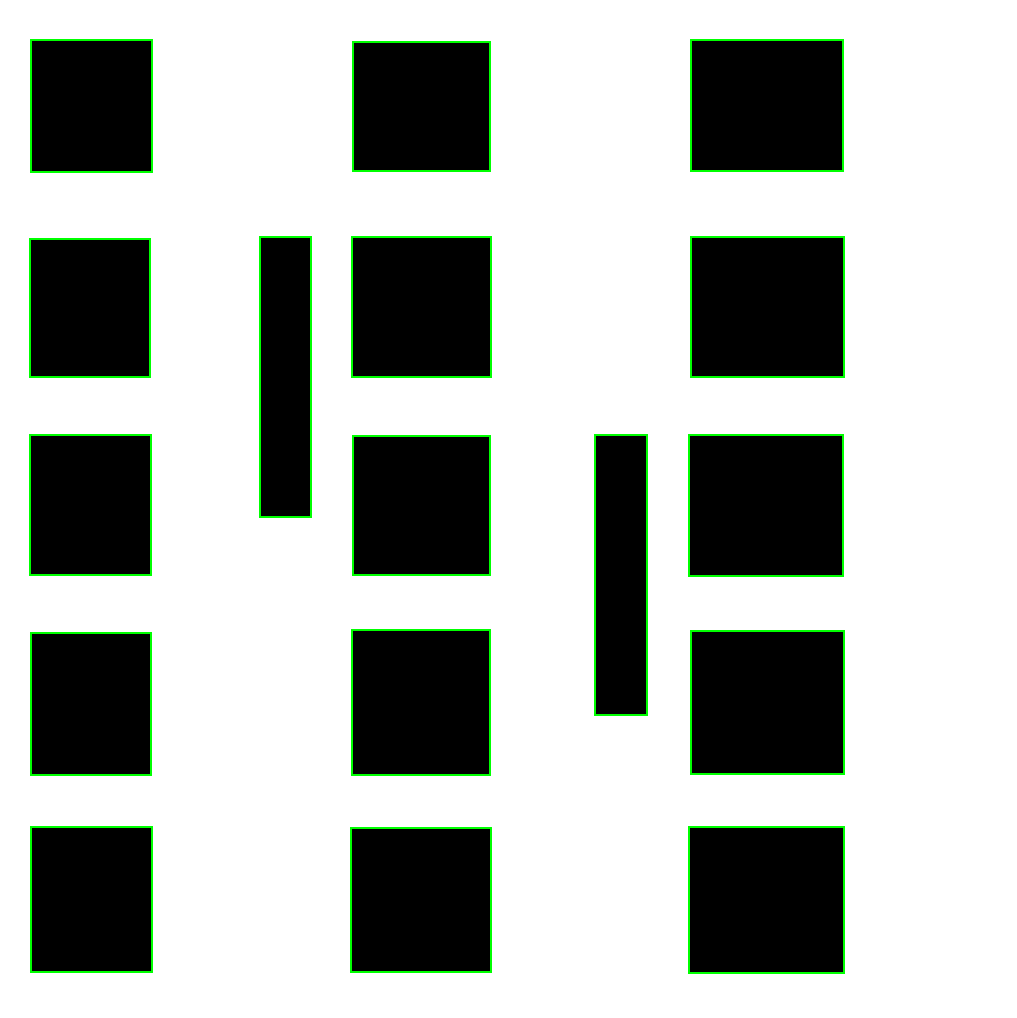

In [10]:
#@title 6) Regenerate geometry (trace modes) + preview
from IPython.display import SVG, display
from PIL import Image
from lxml import etree
import io, cairosvg

def arch_path_d(x, y, width, rect_h, inset=0):
    x0 = x + inset; y0 = y + inset
    w = max(1, width - 2*inset); r = max(1, w//2); rh = max(1, rect_h - inset)
    return f"M {x0},{y0} L {x0},{y0+rh} L {x0+w},{y0+rh} L {x0+w},{y0} A {r},{r} 0 0 0 {x0},{y0} Z"

def make_svg_from_mask(g):
    # --- read params ---
    Wc, Hc = int(g["canvas"]["width"]), int(g["canvas"]["height"])
    floors, bays = int(g["grid"]["floors"]), int(g["grid"]["bays"])
    sx, sy = int(g["grid"]["spacing_x"]), int(g["grid"]["spacing_y"])
    ox, oy = int(g["grid"]["offset_x"]),  int(g["grid"]["offset_y"])
    ww, wh = int(g["window"]["width"]),   int(g["window"]["height"])
    inset   = int(g["window"].get("inset",0))
    shape   = str(g["window"].get("shape","rect")).lower()

    # --- use trace_mode (fallback to old trace_mask_only) ---
    mode = g.get("trace_mode", None)
    if mode is None:
        mode = "on" if g.get("trace_mask_only", True) else "off"   # backward compatible
    # optional size override in trace modes
    use_param_size = bool(g.get("trace_use_param_size", False))

    occ   = g.get("occupancy", [])
    stats = g.get("cell_stats", {})
    occ_rows = len(occ)
    occ_cols = len(occ[0]) if occ_rows else 0

    # --- SVG roots ---
    svg = etree.Element("svg", xmlns="http://www.w3.org/2000/svg",
                        width=str(Wc), height=str(Hc))
    g_fill = etree.SubElement(svg, "g", id="windows_fill", fill="#000000", stroke="none")
    g_outline = etree.SubElement(svg, "g", id="windows_outline", fill="none",
                                 stroke="#00ff00", **{"stroke-width":"2"})

    def draw_rect(x, y, w, h, ins):
        rw = max(1, int(w) - 2*int(ins))
        rh = max(1, int(h) - 2*int(ins))
        etree.SubElement(g_fill, "rect", x=str(int(x)+int(ins)), y=str(int(y)+int(ins)),
                         width=str(rw), height=str(rh))
        etree.SubElement(g_outline, "rect", x=str(int(x)+int(ins)), y=str(int(y)+int(ins)),
                         width=str(rw), height=str(rh))

    def draw_arch(x, y, w, h, ins):
        d = arch_path_d(int(x), int(y), int(w), int(h), int(ins))
        etree.SubElement(g_fill, "path", d=d)
        etree.SubElement(g_outline, "path", d=d)

    def draw_window(x, y, w, h):
        if shape == "arch": draw_arch(x, y, w, h, inset)
        else:               draw_rect(x, y, w, h, inset)

    # ---------- MODE: trace on ----------
    if mode == "on":
        # draw exactly the mask windows (clean match)
        for key, st in stats.items():
            r, c = map(int, key.split("_"))
            if 0 <= r < occ_rows and 0 <= c < occ_cols and occ[r][c]:
                x, y = st["x"], st["y"]
                cw = ww if use_param_size else st.get("med_w", ww)
                ch = wh if use_param_size else st.get("med_h", wh)
                draw_window(x, y, cw, ch)

    # ---------- MODE: trace off ----------
    elif mode == "off":
        # ignore mask; full parametric grid
        for r in range(floors):
            for c in range(bays):
                x = ox + c*sx; y = oy + r*sy
                draw_window(x, y, ww, wh)

    # ---------- MODE: trace grow ----------
    else:  # "grow"
        # 1) draw mask windows inside bounds (preserve gaps)
        for key, st in stats.items():
            r, c = map(int, key.split("_"))
            if 0 <= r < occ_rows and 0 <= c < occ_cols and occ[r][c]:
                x, y = st["x"], st["y"]
                cw = ww if use_param_size else st.get("med_w", ww)
                ch = wh if use_param_size else st.get("med_h", wh)
                draw_window(x, y, cw, ch)
        # 2) add new rows beyond mask bounds
        for r in range(occ_rows, floors):
            for c in range(bays):
                x = ox + c*sx; y = oy + r*sy
                draw_window(x, y, ww, wh)
        # 3) add new columns beyond mask bounds for existing mask rows
        for r in range(min(floors, occ_rows)):
            for c in range(occ_cols, bays):
                x = ox + c*sx; y = oy + r*sy
                draw_window(x, y, ww, wh)

    return etree.tostring(svg, pretty_print=True).decode("utf-8")

print("Trace mode:", grammar.get("trace_mode", "on"),
      "| shape:", grammar["window"].get("shape"),
      "| use_param_size_in_trace:", grammar.get("trace_use_param_size", False))

param_svg = make_svg_from_mask(grammar)
with open("facade_parametric.svg","w") as f:
    f.write(param_svg)
display(SVG(data=param_svg))

def svg_to_rgba(svg_text, Wc, Hc, bg="white"):
    png_bytes = cairosvg.svg2png(bytestring=svg_text.encode("utf-8"),
                                 output_width=int(Wc), output_height=int(Hc),
                                 background_color=bg)
    return Image.open(io.BytesIO(png_bytes)).convert("RGBA")

if facade_img is not None:
    Wc, Hc = int(grammar["canvas"]["width"]), int(grammar["canvas"]["height"])
    overlay = Image.blend(facade_img, svg_to_rgba(param_svg, Wc, Hc, bg="white"), alpha=0.35)
    display(overlay)


In [11]:
#@title 7) Export JSON + DXF (trace-mode aware)
with open("facade_grammar.json","w") as f:
    json.dump(grammar, f, indent=2)
print("Saved facade_grammar.json")

doc = ezdxf.new(); msp = doc.modelspace()
floors, bays = int(grammar["grid"]["floors"]), int(grammar["grid"]["bays"])
sx, sy = int(grammar["grid"]["spacing_x"]), int(grammar["grid"]["spacing_y"])
ox, oy = int(grammar["grid"]["offset_x"]),  int(grammar["grid"]["offset_y"])
ww, wh = int(grammar["window"]["width"]),  int(grammar["window"]["height"])
inset   = int(grammar["window"].get("inset",0))
shape   = str(grammar["window"].get("shape","rect")).lower()
occ     = grammar.get("occupancy", [])
stats   = grammar.get("cell_stats", {})
mode    = grammar.get("trace_mode", "on")   # "on" | "off" | "grow"

def add_rect(x,y,w,h,ins):
    rw = max(1, int(w)-2*ins); rh = max(1, int(h)-2*ins)
    x0, y0 = int(x)+ins, int(y)+ins
    msp.add_lwpolyline([(x0,y0),(x0+rw,y0),(x0+rw,y0+rh),(x0,y0+rh),(x0,y0)])

for r in range(floors):
    for c in range(bays):
        key = f"{r}_{c}"

        # mode gating
        if mode == "on":
            if not (0 <= r < len(occ) and 0 <= c < len(occ[0]) and occ[r][c]):
                continue
        elif mode == "grow":
            if r < len(occ) and c < len(occ[0]) and not occ[r][c]:
                continue
        # mode == "off": no gating (export full grid)

        # position/size source
        if key in stats and mode in ("on","grow"):
            x, y = stats[key]["x"], stats[key]["y"]
            cw, ch = stats[key].get("med_w", ww), stats[key].get("med_h", wh)
        else:
            x, y = ox + c*sx, oy + r*sy
            cw, ch = ww, wh

        if shape == "arch":
            # simple: export as rect footprint + (optional) arc polyline
            add_rect(x,y,cw,ch,inset)
            # (optional) add an arc here if you need it in DXF
        else:
            add_rect(x,y,cw,ch,inset)

doc.saveas("facade_parametric.dxf")
print("Saved facade_parametric.dxf")


Saved facade_grammar.json
Saved facade_parametric.dxf


In [12]:
#@title 8) Mini UI — trace modes + live edits → regenerate → preview
import ipywidgets as widgets
from IPython.display import SVG, display

# auto-align helper (same as you ran after Step 4)
def align_grid_to_mask(g):
    import numpy as np
    stats = g.get("cell_stats", {})
    occ   = g.get("occupancy", [])
    if not occ or not stats: return g
    rows = len(occ); cols = len(occ[0]) if rows else 0
    row_y, col_x = [], []
    for r in range(rows):
        ys = [stats[f"{r}_{c}"]["y"] for c in range(cols) if f"{r}_{c}" in stats]
        if ys: row_y.append(int(np.median(ys)))
    for c in range(cols):
        xs = [stats[f"{r}_{c}"]["x"] for r in range(rows) if f"{r}_{c}" in stats]
        if xs: col_x.append(int(np.median(xs)))
    row_y.sort(); col_x.sort()
    if row_y: g["grid"]["offset_y"]  = int(row_y[0])
    if col_x: g["grid"]["offset_x"]  = int(col_x[0])
    if len(row_y) > 1: g["grid"]["spacing_y"] = int(np.median(np.diff(row_y)))
    if len(col_x) > 1: g["grid"]["spacing_x"] = int(np.median(np.diff(col_x)))
    return g

# Defaults
if "trace_mode" not in grammar:
    grammar["trace_mode"] = "on"

prompt = widgets.Text(
    value="trace off; set floors 7; set bays 5; set spacing x 180px; set spacing y 220px; set offset x 10px; set offset y 10px; rect",
    placeholder="e.g., 'trace grow; add 2 floors; make windows 20% wider; rect'",
    description="Edit:"
)
apply_btn = widgets.Button(description="Apply", button_style="success")
trace_toggle = widgets.ToggleButtons(
    options=[("Trace ON","on"), ("Trace OFF","off"), ("Trace GROW","grow")],
    value=grammar.get("trace_mode","on"),
    description="Trace:"
)
out = widgets.Output()

def regen_preview():
    # auto-align whenever OFF or GROW so rows don't overlap
    if grammar.get("trace_mode") in ("off","grow"):
        align_grid_to_mask(grammar)
    # sanity print
    occ = grammar.get("occupancy", [])
    print(
        "trace_mode:", grammar.get("trace_mode"),
        "| floors:", grammar["grid"]["floors"], "bays:", grammar["grid"]["bays"],
        "| spacing_x/y:", grammar["grid"]["spacing_x"], grammar["grid"]["spacing_y"],
        "| offset_x/y:", grammar["grid"]["offset_x"], grammar["grid"]["offset_y"],
        "| occ_rows/cols:", len(occ), (len(occ[0]) if occ else 0)
    )
    # render
    global param_svg
    param_svg = make_svg_from_mask(grammar)
    with open("facade_parametric.svg","w") as f:
        f.write(param_svg)
    out.clear_output()
    with out:
        display(SVG(data=param_svg))

def on_apply_clicked(b):
    global grammar
    grammar = apply_rules(prompt.value, grammar)
    grammar["trace_mode"] = trace_toggle.value  # toggle wins
    regen_preview()

def on_trace_change(change):
    if change["name"] == "value":
        grammar["trace_mode"] = change["new"]
        regen_preview()

apply_btn.on_click(on_apply_clicked)
trace_toggle.observe(on_trace_change, names="value")

regen_preview()
display(widgets.VBox([trace_toggle, prompt, apply_btn, out]))


trace_mode: on | floors: 5 bays: 5 | spacing_x/y: 162 196 | offset_x/y: 31 40 | occ_rows/cols: 5 5
